In [1]:
import numpy as np
import numpy.matlib
import math
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import bisect

In [2]:
train = np.genfromtxt ('letters.csv', delimiter=",")
trainlabels = np.genfromtxt ('letterslabels.csv', delimiter=",")
[n,m]  = np.shape(train) 
#n is 7744 each 88x88 pixel image
#m is 7000 images stored

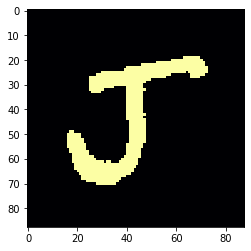

In [9]:
#normalisation
pix = int(math.sqrt(n))
normW = np.sqrt(np.diag(train.T.dot(train)))
train = train / normW 
image = np.reshape(train[:,2],(pix,pix),order="F")
plt.imshow(image, cmap = 'inferno');

In [4]:
# parameter controlling magnitude of initial conditions
winit  = 1                                  
alpha = 0.999
#number of iterations 
tmax   = 20000
#number of output neurons
letters = 16

eta    = 0.2 # winner learning rate
l_eta = eta / 4 #loser learning rate

#random number up to number of images stored for number of output neurons
random_indicies = [random.randint(0, m) for x in range(letters)]

#function to perform competative learning
def competitive(setNoise,setDecay,setLeaky,setNeighbour):
    # Transposed Weight matrix (rows = output neurons, cols = input neurons)
    W = train[:, random_indicies].T
    #initilise the counter as an array to track the winning neurons
    counter = np.zeros(letters)
    #initilise the running average - weight change over time
    wCount = np.ones((1,tmax+1)) * 0.25 
    
    for t in range(1,tmax):
        beta = 1/100000
        i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
        x = train[:,i]                          # pick a training instance using the random index
        #to generate noise create a random vector and multipliy it with the train vector
        if setNoise:
            noise = np.random.rand(x.shape[0])/1000
            x = x*noise
        h = W.dot(x)/letters                     # get output firing
        h = h.reshape(h.shape[0],-1)            # reshape h into a numpy 2d array


        k = np.argmax(h)                    # get the index of the firing neuron
        counter[k] += 1                    # increment counter for winner neuron

        dw = eta * (x.T - W[k,:])      #update weight of winning neuron
        
        # update weight of winning neuron but with a decay rate correlated to number of wins that neuron has
        if setDecay:
            dw = (eta/(1+(((counter[k]/100))))) * (x.T - W[k,:]) 

        #update matricies
        W[k,:] = W[k,:] + dw    
        wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha))

        if setNeighbour:
            sorted = np.flip(np.argsort(h,axis=0)) #rank the winning neurons
            k2 = sorted[1] #second place neurons
            k3 = sorted[2] #third place neurons
            dw2 = l_eta * (x.T - W[k2,:]) #apply loosing learning rate 
            dw3 = l_eta * (x.T - W[k3,:]) 
            counter[k2] += 0.5 #award 0.5 to second place
            counter[k3] += 0.25 #award 0.25 to third place
            #update running average matrix with winner and neighbours ( 2nd and 3rd winners)
            wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) * (alpha + dw2.dot(dw2.T)*(1-alpha))* (alpha + dw3.dot(dw3.T)*(1-alpha))

        if setLeaky:
            #update weights with losing rate for all before the winner in matrix
            dw0Total = None
            for a in range(0,k):
                dw0 = l_eta * (x.T - W[a,:])
                W[a,:] = W[a,:] + dw0[a]
                if dw0Total is None:
                    dw0Total = dw0
                else:
                    dw0Total += dw0
                    
            #update weights with losing rate for all after the winner in matrix
            dw2Total = None
            for b in range(k+1, letters):
                dw2 = l_eta * (x.T - W[b,:])
                W[b,:] = W[b,:] + dw2[b]
                if dw2Total is None:
                    dw2Total = dw2
                else:
                    dw2Total += dw2
                    
            #update running average matrix with winner all losers        
            wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha))
            if dw0Total is not None:
                wCount[0,t] = wCount[0,t] * (alpha + dw0Total.dot(dw0Total.T)*(1-alpha))
            if dw2Total is not None:
                wCount[0,t] = wCount[0,t] * (alpha + dw2Total.dot(dw2Total.T)*(1-alpha))
                
                

    return wCount, counter, W

In [5]:
# function for post processing
#prints dead neurons, SD and iteration where learning change is less than 0.00001
def results(wCount,counter):
    dead_weight = 0
    index = np.arange(letters)
    #plt.bar(index, counter)
    print("SD : " , np.std(counter))
    for x in counter:
        if x < (np.mean(counter)/2):
            dead_weight +=1
    print("Number of dead weights : ",  dead_weight)
    index = bisect.bisect((list(wCount[0]))[::-1], 0.00001)
    #learn_test = (list(wCount[0]))[index-1]
    print("Iteration of learning change below threshold :",  (tmax - index))

    print("-----------")
    
#---- uncomment to run (setNoise,setDecay,setLeaky,setNeighbour)------#    

wCount, counter, W = competitive(0,0,0,0)
results(wCount, counter)

wCount, counter, W = competitive(1,0,0,0)
results(wCount, counter)

wCount, counter, W = competitive(0,1,0,0)
results(wCount, counter)

#wCount, counter, W = competitive(1,1,0,0)
#results(wCount, counter)

#wCount, counter, W = competitive(0,0,1,0)
#results(wCount, counter)

#wCount, counter, W = competitive(1,1,1,0)
#results(wCount, counter)

#wCount, counter, W = competitive(0,0,0,1)
#results(wCount, counter)

#wCount, counter, W = competitive(1,1,0,1)
#results(wCount, counter)



SD :  764.8462646792165
Number of dead weights :  4
Iteration of learning change below threshold : 10387
-----------
SD :  626.908233790042
Number of dead weights :  3
Iteration of learning change below threshold : 10123
-----------
SD :  1122.8233648235816
Number of dead weights :  7
Iteration of learning change below threshold : 10153
-----------


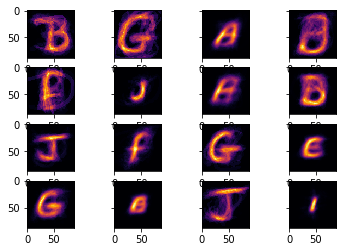

In [6]:
# print the prototypes
fig, axis = plt.subplots(4,4, sharey=True)
count=0
for x in range(4):
    for y in range(4):
        axis[x,y].imshow(W[count,:].reshape((88,88), order = 'F'),interpolation = 'nearest', cmap='inferno')
        count+=1

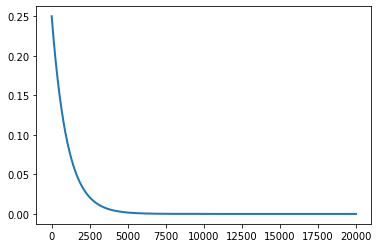

In [7]:
#produce the average weight change over time graph
plt.plot(wCount[0,0:tmax], linewidth=2.0, label='rate')

In [8]:
#print the correlation matrix between the prototypes
print(numpy.corrcoef(W))

[[ 1.00000000e+00  1.88579210e-01  3.25189133e-01  4.28633481e-01
   3.58534382e-01  2.68468531e-01  2.75160753e-01  4.73024549e-01
   3.27881401e-01  3.77098750e-01  2.89748398e-01  1.85921783e-01
   2.18315170e-01  2.81642922e-01  3.84937917e-01  3.58669365e-01]
 [ 1.88579210e-01  1.00000000e+00  6.97812843e-02  3.65048446e-01
   2.74060530e-01  9.16064000e-02 -2.81719401e-04  1.60371639e-01
   5.02206680e-02  3.89261125e-02  4.98255930e-01 -6.68422496e-02
   1.48038927e-01  2.25208647e-02  2.85125044e-01  3.47118930e-02]
 [ 3.25189133e-01  6.97812843e-02  1.00000000e+00  4.00451712e-01
   3.88578256e-01  5.11183265e-01  7.30710163e-01  6.24755332e-01
   5.05378356e-01  6.27535055e-01  3.83513459e-01  7.19442652e-01
   5.59859187e-01  7.87063368e-01  2.58464517e-01  3.57111013e-01]
 [ 4.28633481e-01  3.65048446e-01  4.00451712e-01  1.00000000e+00
   5.08055953e-01  1.01941689e-01  4.55095817e-01  5.14007043e-01
   2.11809837e-01  3.18642225e-01  2.72908458e-01  2.24531625e-01
   2.96